# Notebook to generate the plots in the Repport

In [1]:
## imports
import torch 
from stimulus import *
from BIRNN import *
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

from tqdm import trange

import ipywidgets as widgets
from ipywidgets import interact_manual, FloatSlider
from IPython.display import display,  clear_output

current_dir_path = os.getcwd()
figure_directory_name = 'repport_figures'
figures_directory_path = os.path.join(current_dir_path, figure_directory_name)
if not os.path.exists(figures_directory_path):
    os.mkdir(figures_directory_path)

### Code to generate 2 signal and expected output examples. One positive, one negative

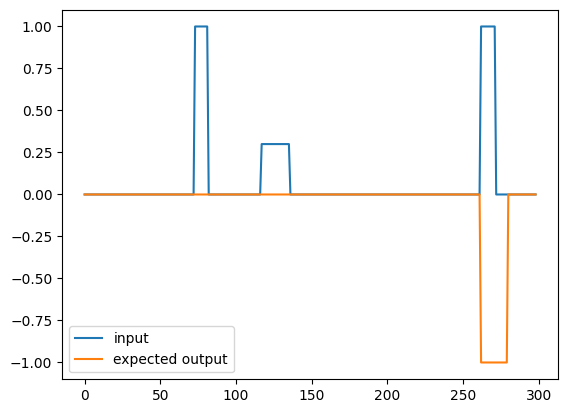

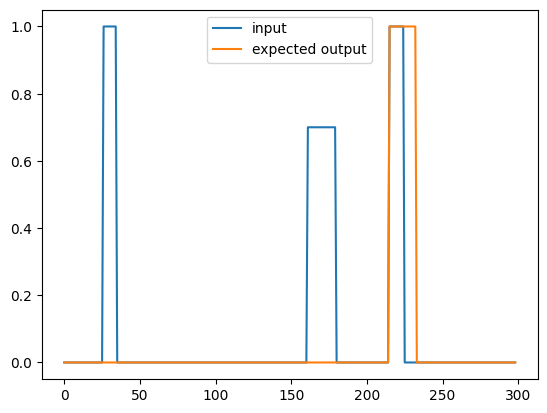

In [2]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=True)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
# d_i, d_o = stimG.concat_sim(d_i, d_o)

fig_signal1 =plt.figure()
ax = fig_signal1.add_subplot()
ax.plot(d_i[0], label = 'input')
ax.plot(d_o[0], label = 'expected output')
ax.legend()
#fig_signal1.show()
fig_signal1.savefig(figures_directory_path + '/signal1.pdf')

fig_signal2 =plt.figure()
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=False)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
ax = fig_signal2.add_subplot()
ax.plot(d_i[0], label = 'input')
ax.plot(d_o[0], label = 'expected output')
ax.legend()
#fig_signal2.show()
fig_signal2.savefig(figures_directory_path + '/signal2.pdf')


## Biffurcation diagram for BRC

In [3]:
def pulse(t, begin , end):    
    return  np.heaviside(t - begin, 0) - np.heaviside(t - end, 0)

def make_BRC_trajectory_plots():
    fig, ax = plt.subplots()

    hfs = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), indexing='ij')
    hfs = np.concatenate((np.expand_dims(hfs[0], 0), np.expand_dims(hfs[1], 0)))

    t_steps = np.arange(500)
    a_t = np.linspace(0,2,500)
    x_t = 0.1 * np.sin(t_steps/10)

    trajectory = [0.0]

    def get_ode(pars):
        _, c, x = pars['a'], pars['c'], pars['x']

        def f(a, hf):
            return c * hf + (1 - c) * np.tanh(x + a * hf)

        return f

    def animate(frame_num):
        ax.clear()
        pars = {'a': a_t[frame_num],
                'c': 0.3,
                'x': x_t[frame_num]}

        func = get_ode(pars)
        ax.contourf(hfs[0], hfs[1], func(hfs[0], hfs[1]) - hfs[1], 0)
        trajectory.append(func(a_t[frame_num], trajectory[-1]))
        ax.set_title("Time_step: " + str(frame_num) + ' Input = ' + str(x_t[frame_num]))
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(-2, 2)
        ax.set_xlabel("a")
        ax.set_ylabel("cell output")
        ax.plot(a_t[:frame_num], trajectory[:frame_num], 'r')
        ax.plot(a_t[frame_num], trajectory[frame_num], 'ro')

    anim = FuncAnimation(fig, animate, frames=499, interval=100, repeat=True, repeat_delay=500)
    anim.save(figures_directory_path + "/BRC_trajectory.gif", writer='pillow')
    
    pars = {'a': 1,
            'c': 0.3,
            'x': 0}

    func = get_ode(pars)
    ax.clear()
    ax.contourf(hfs[0], hfs[1], func(hfs[0], hfs[1]) - hfs[1], 0)

    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-2, 2)
    ax.set_xlabel("a")
    ax.set_ylabel("cell output")
    ax.plot(a_t[:500], trajectory[:500], 'r')
    ax.plot(a_t[-1], trajectory[-1], 'ro')
    fig.savefig(figures_directory_path + "/BRC_trajectory.pdf",)

#make_BRC_trajectory_plots()

## Charachteristic BEF trajectories and phase planes

In [4]:
def update_BEF_plots_random(button):
    def BEF_transition(hf, hs, pars,input = 0):
        # size (B, V)
        a,b,c,d,e = pars['a'],pars['b'],pars['c'],pars['d'],pars['e']
        hfn = hf * (1-c) + c*torch.tanh(input  + (a + b*hf**2 - hs)*hf) #0 input response
        hsn = hs*(1-d) + d*(e*hf)**4
        return hfn, hsn 

    clear_output(wait=True)
    
    a = np.random.uniform(0, 2)
    b = np.random.uniform(0, 3)
    c = np.random.uniform(0.3, 1)
    d = np.random.uniform(0.03, 0.3)
    e = np.random.uniform(0, 2)
    
    pars = {'a': a, 'b': b, 'c': c, 'd': d, 'e': e}
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    ### parameters to generate a trajectory
    trajectory_times_steps = 500
    trajectory = [[torch.tensor(0),torch.tensor(0)]]        
    input_amplitude = 1
    input_signal = input_amplitude * pulse(np.arange(trajectory_times_steps),50,150)
    input_signal = input_signal  - pulse(np.arange(trajectory_times_steps),300,350)

    
    # Phase portrait and trajectory plot
    hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))
    hfn, hsn = BEF_transition(hfs[0], hfs[1], pars, input_amplitude)
    axs[0].contourf(hfs[1], hfs[0], hfn - hfs[0], 0)
    axs[0].contour(hfs[1], hfs[0], hsn - hfs[1], 0)
    axs[0].set_title(f'Parameters: a={a:.2f}, b={b:.2f}, c={c:.2f}, d={d:.2f}, e={e:.2f}')
    axs[0].set_xlabel('Fast Variable')
    axs[0].set_ylabel('Slow Variable')
    
    ## generate the trajectory
    for i in range(trajectory_times_steps):
        next_fast, next_slow = BEF_transition(trajectory[-1][0], trajectory[-1][1], pars, input=input_signal[i])
        trajectory.append([next_fast, next_slow])
    trajectory = np.array(trajectory)
    axs[0].plot(trajectory[:, 1], trajectory[:, 0], label="trajectory", color="r")
    axs[0].legend()
    
    # Fast, slow, and input signal plot
    axs[1].plot(trajectory[:, 0], label="Fast Variable")
    axs[1].plot(trajectory[:, 1], label="Slow Variable")
    axs[1].plot(input_signal, label="Input Signal")
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Fast, Slow, and Input Signal')
    axs[1].legend()
    
    plt.tight_layout()
    display(button)
    plt.show()
    

button = widgets.Button(description='Randomize Parameters')
button.on_click(update_BEF_plots_random)
display(button)

Button(description='Randomize Parameters', style=ButtonStyle())

# Load trained models

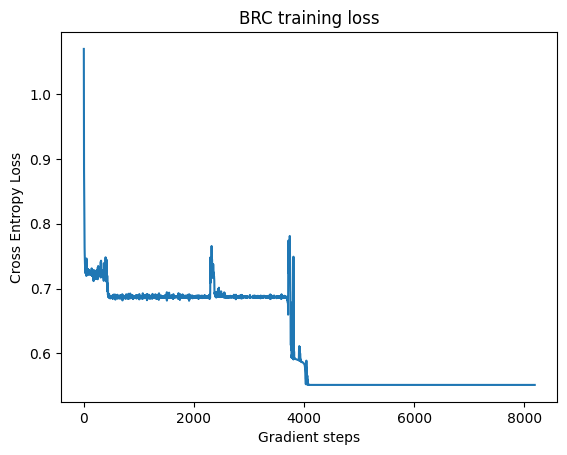

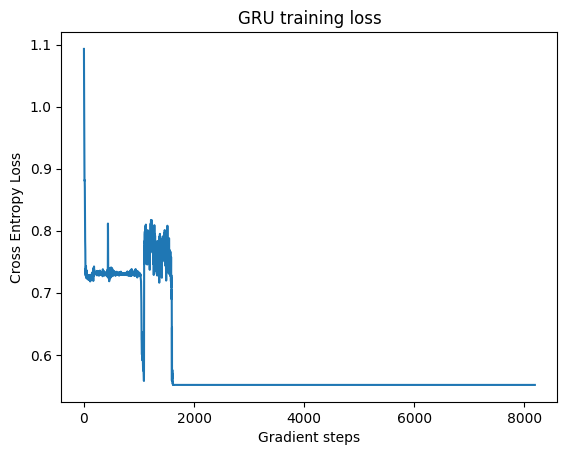

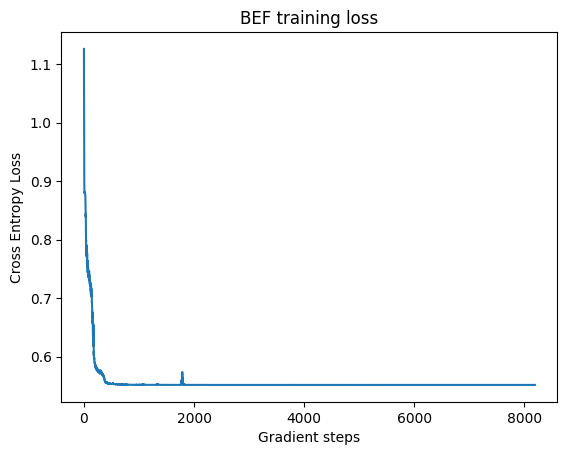

In [5]:
def load_trained_model(memory_cell_type):
    memory_size = 128
    in_emb = memory_size//4
    mem_lay = 1
    inputs_dim = 2
    decisions = 3
    sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
    actor = ResMLP(memory_size, decisions, [64,64,64])

    model = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                        mem_lay=mem_lay, decisions=decisions, type = memory_cell_type)
    modelfname = f'./results_train/checkpoint_{memory_cell_type}.pth'
    lossfname = f'./results_train/loss_{memory_cell_type}.pt'
    state = torch.load(modelfname, map_location=torch.device('cpu'))
    loss = torch.load(lossfname, map_location=torch.device('cpu'))
    
    ## plot losses
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss)
    ax.set_xlabel('Gradient steps')
    ax.set_ylabel('Cross Entropy Loss')
    ax.set_title((memory_cell_type + ' training loss'))
    fig.savefig(figures_directory_path +'/'+ memory_cell_type +'_training_loss'+ '.pdf')
    
    ## load model
    model.load_state_dict(state)
    
    return model

trained_models = {}
t_m = load_trained_model('BRC')
trained_models['BRC'] = t_m
t_m = load_trained_model('GRU')
trained_models['GRU'] = t_m
t_m = load_trained_model('BEF')
trained_models['BEF'] = t_m

### Heatmap plots for high and low imput to each modem

In [6]:
def plot_heatmap(pred_c, input_signal,plot_title = ""):
    # Get the shape of pred_c and input_signal
    num_timesteps, num_neurons = pred_c.shape

    # Create a meshgrid for the time steps and neuron numbers
    timesteps, neurons = np.meshgrid(range(num_timesteps), range(num_neurons))

    # Create subplots for both heatmaps
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[0.95, 0.05], height_ratios=[10, 0.5])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[:, 1])

    # Plot pred_c heatmap
    pcm1 = ax1.pcolormesh(timesteps, neurons, pred_c.T, shading='auto', cmap='coolwarm', vmin = -1, vmax = 1)
    ax1.set_ylabel('Neuron Number')
    ax1.set_title('Heatmap of memory output')

    # Plot mod_in heatmap
    x = np.arange(num_timesteps)
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax2.imshow(input_signal[np.newaxis,:], cmap="coolwarm", aspect="auto", extent=extent,vmin = -1, vmax = 1)
    #ax2.pcolormesh(np.arange(num_timesteps), input_signal, shading='auto', cmap='coolwarm', vmin = -1, vmax = 1)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Input')
    ax2.set_title('Input signal')
    ax2.margins(x=0)
    # Add colorbar
    cbar = fig.colorbar(pcm1, cax=cax)
    cbar.set_label('Memory Output Level')

    fig.savefig(figures_directory_path +'/'+plot_title + '.pdf')
    plt.tight_layout()
    plt.show()

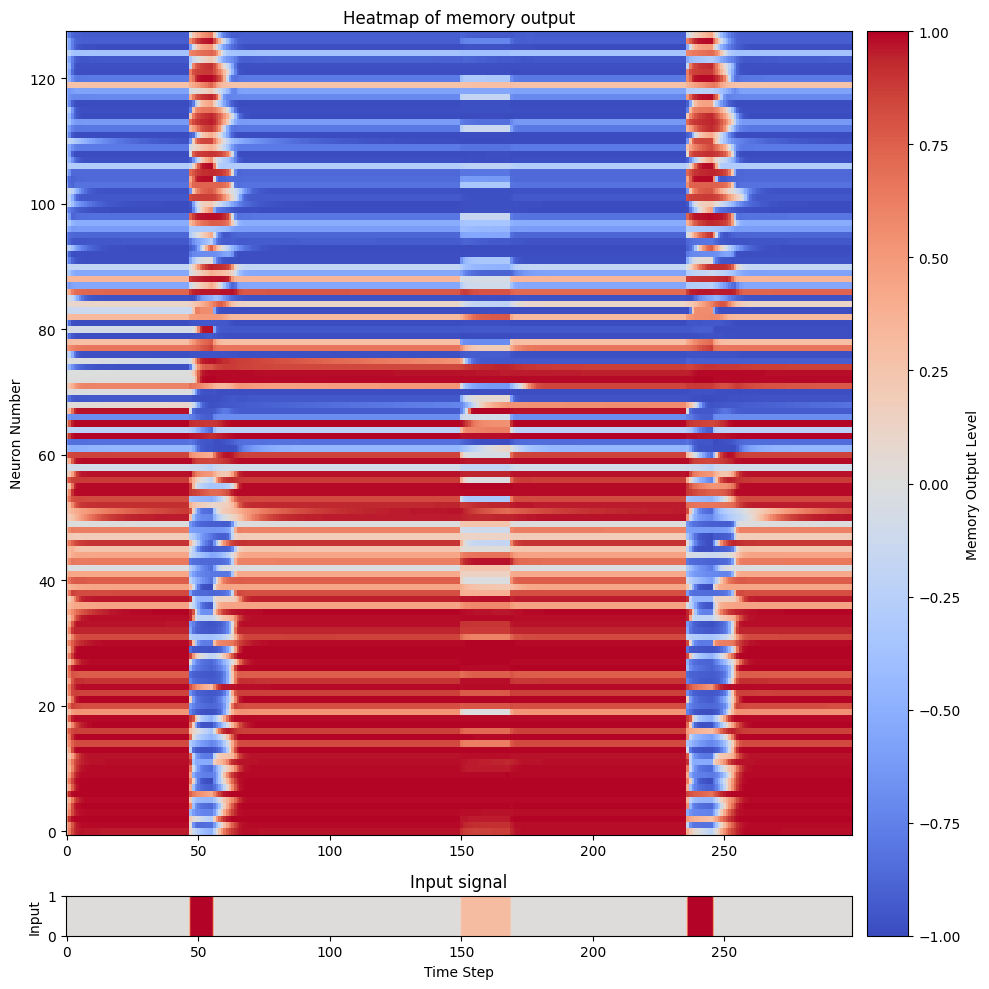

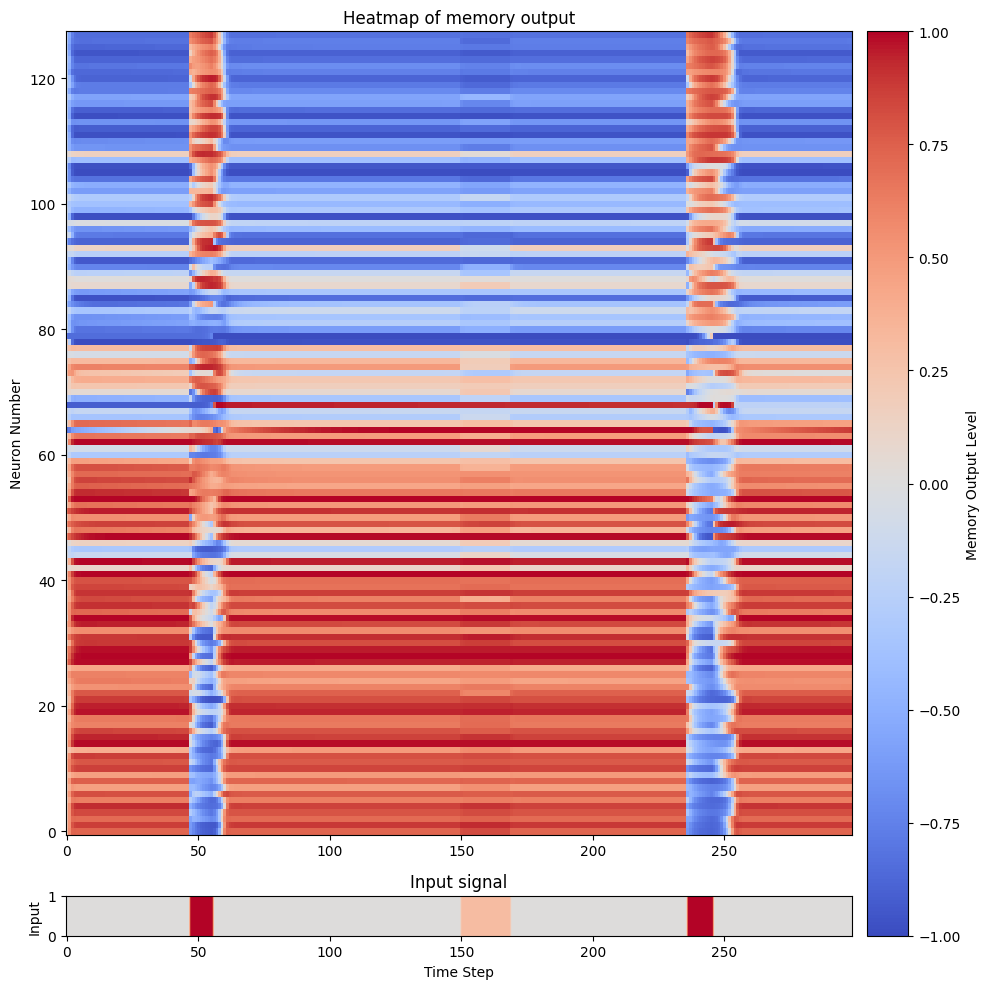

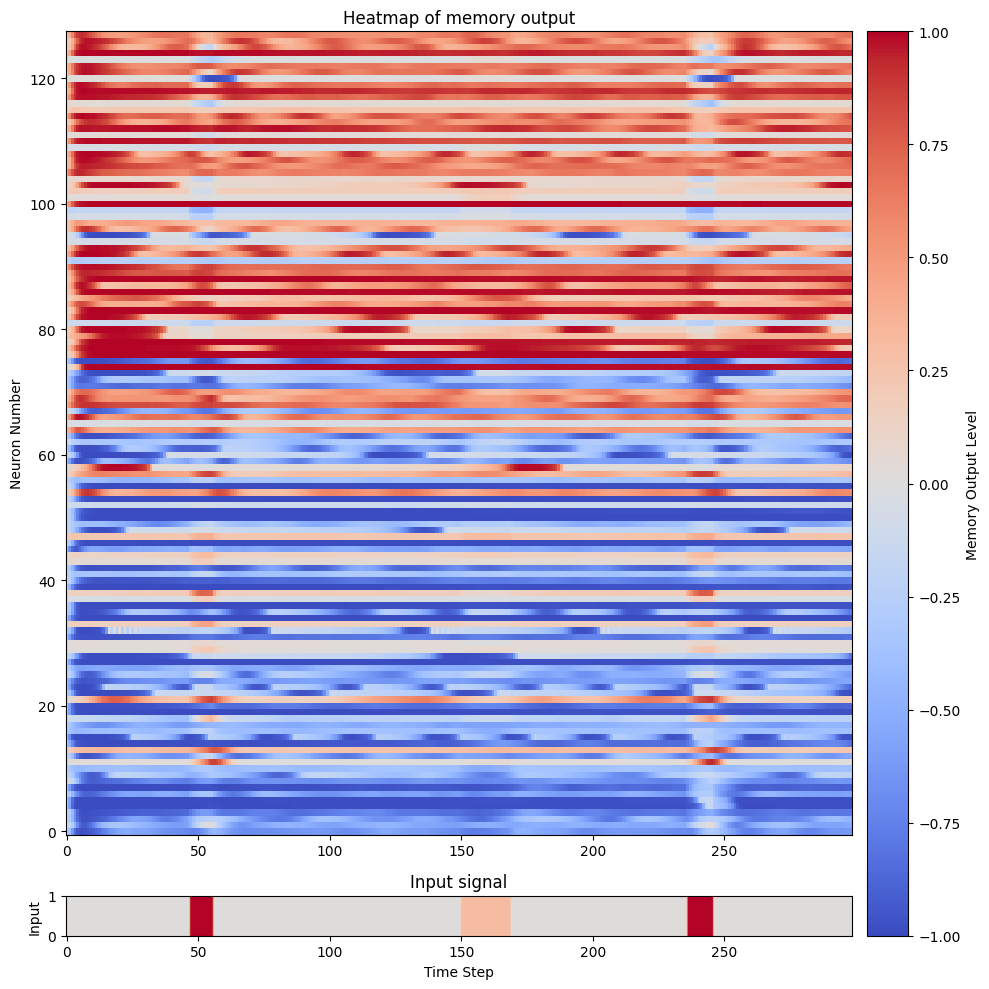

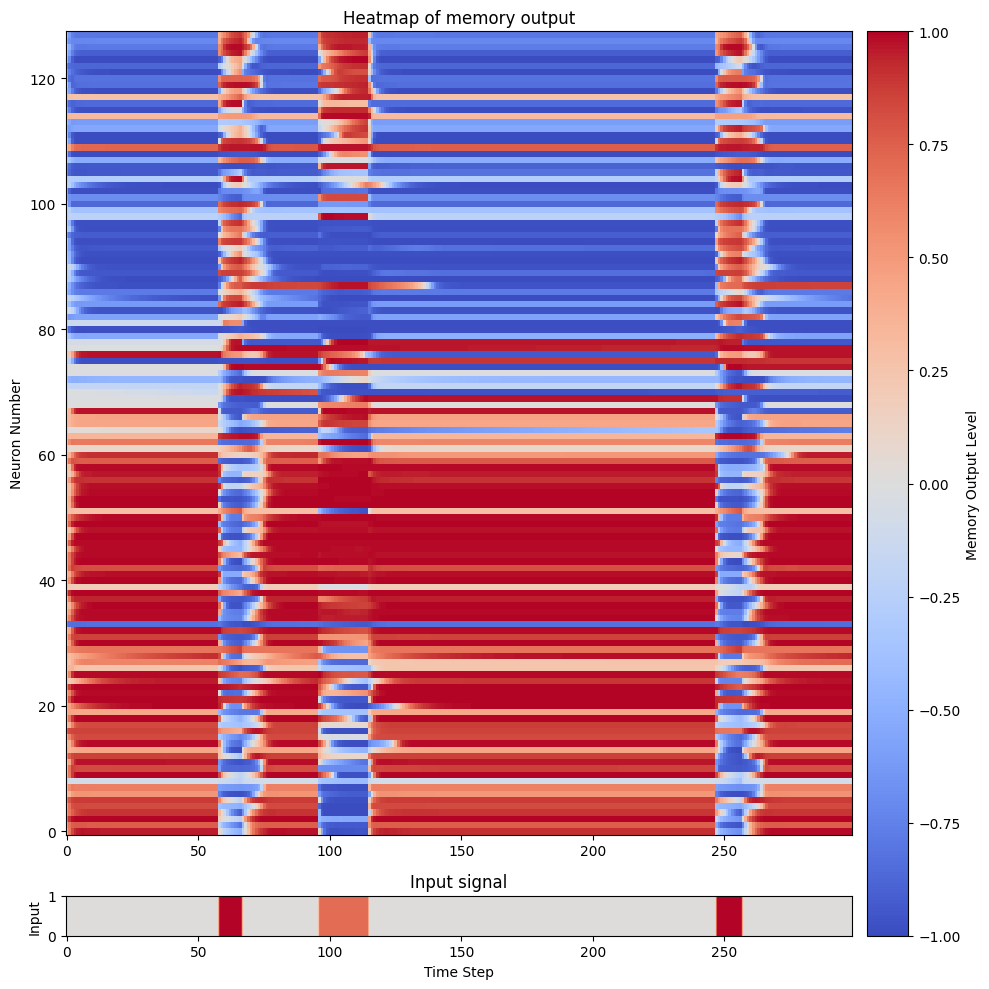

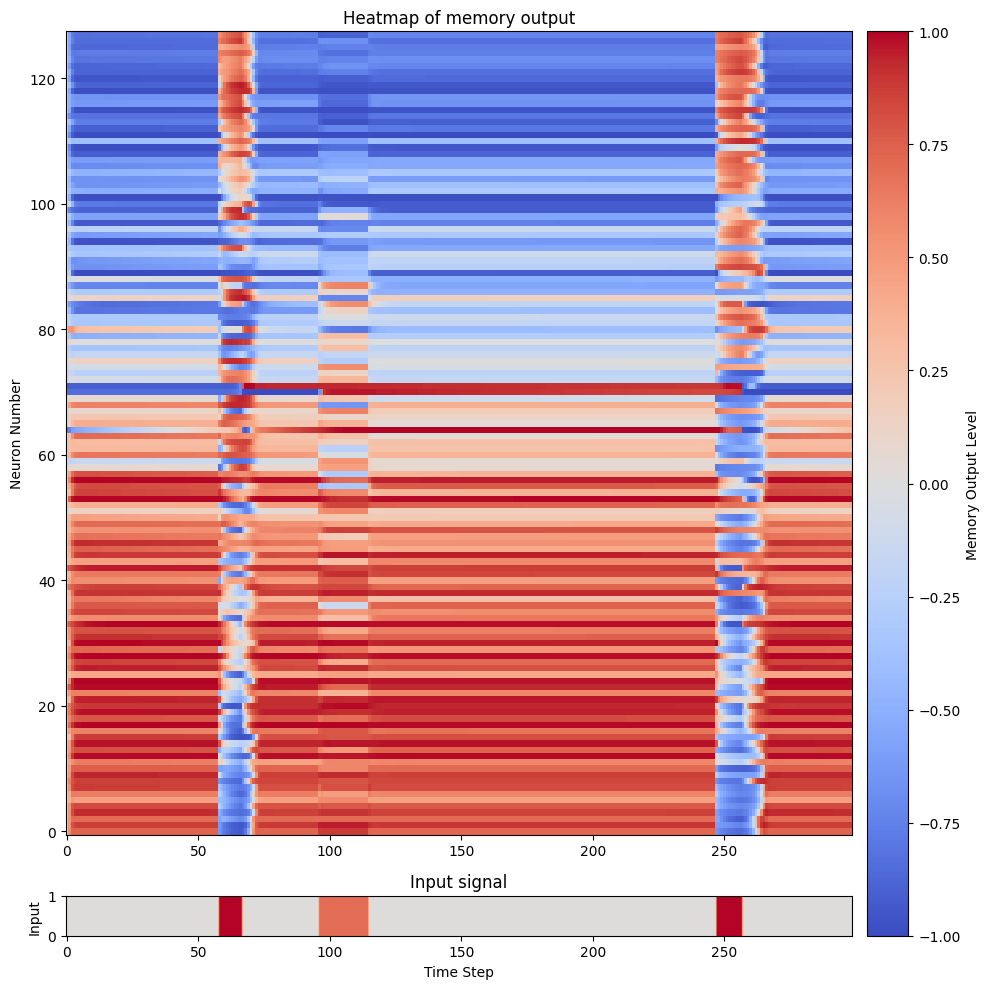

torch.Size([1, 299, 32])


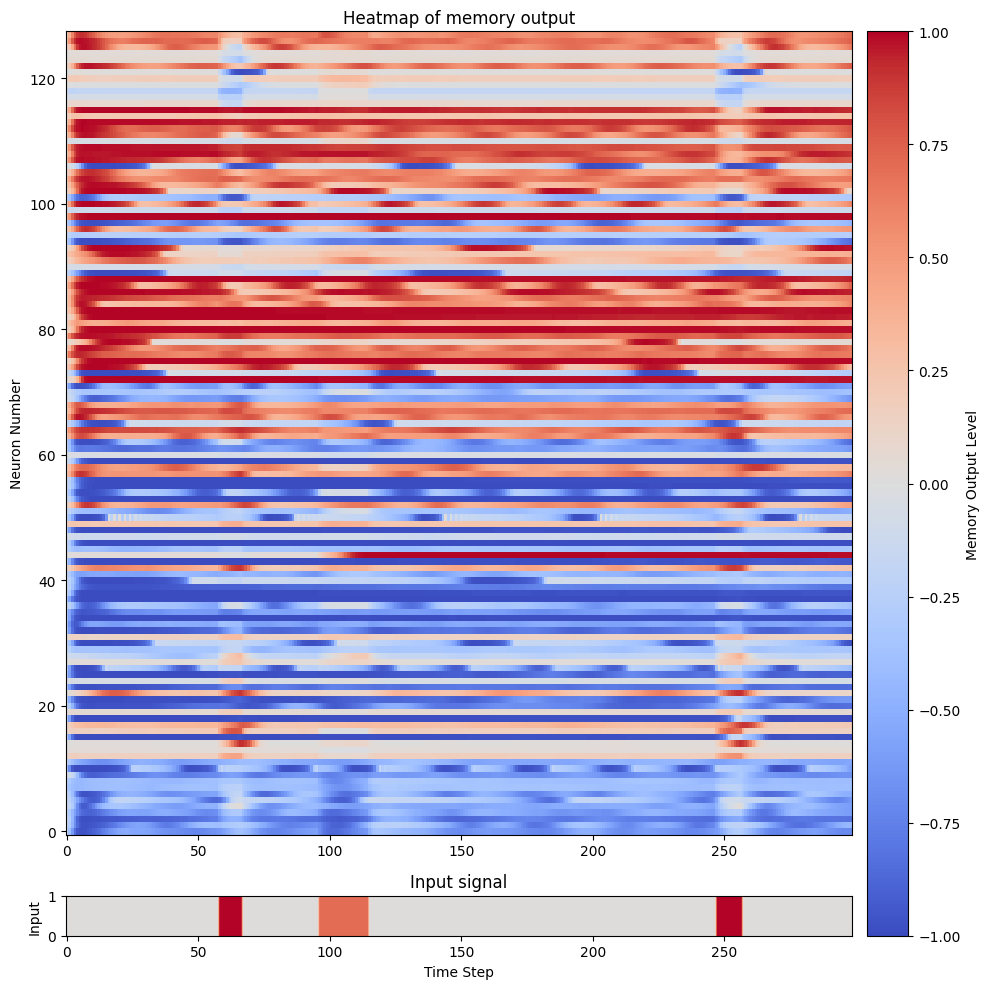

In [7]:
# make a Low input signal
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=True)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
B, L = d_i.shape
signal_low = torch.zeros((B,L,2))
signal_low[...,0][d_i == 1] = 1
signal_low[...,1][d_i != 1] = d_i[d_i!=1]

for cell_type in trained_models:
    
    with torch.no_grad():
        model = trained_models[cell_type]
        if cell_type == 'BEF': 
            packed = model.forward(x=signal_low, debug_mem=True)
            a,b,c,d,e,fast_var, slow_var = packed
        elif cell_type == 'BRC':
            a,c,fast_var = model.forward(x=signal_low, debug_mem=True)
        else:
            fast_var = model.forward(x=signal_low, debug_mem=True)
            
    toOrder = fast_var[0].T
    corr = torch.corrcoef(toOrder)
    idx = corr[0].argsort(descending = True)
    plot_heatmap(fast_var[0,:,idx],d_i[0],(cell_type + "_heatmap_low_input"))
    

# make a High input signal
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=False)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
B, L = d_i.shape
signal_high = torch.zeros((B,L,2))
signal_high[...,0][d_i == 1] = 1
signal_high[...,1][d_i != 1] = d_i[d_i!=1]

for cell_type in trained_models:
    
    with torch.no_grad():
        model = trained_models[cell_type]
        if cell_type == 'BEF': 
            packed = model.forward(x=signal_high, debug_mem=True)
            a,b,c,d,e,fast_var, slow_var = packed
            print(model.sense.forward(signal_high).shape)
        elif cell_type == 'BRC':
            a,c,fast_var = model.forward(x=signal_high, debug_mem=True)
        else:
            fast_var = model.forward(x=signal_high, debug_mem=True)
    
    toOrder = fast_var[0].T
    corr = torch.corrcoef(toOrder)
    idx = corr[0].argsort(descending = True)
    plot_heatmap(fast_var[0,:,idx],d_i[0],(cell_type + "_heatmap_hig_input"))


### Generate 2D and 3D PCA trajectories with plots of captured variance in each component

##### PCA decomposition code

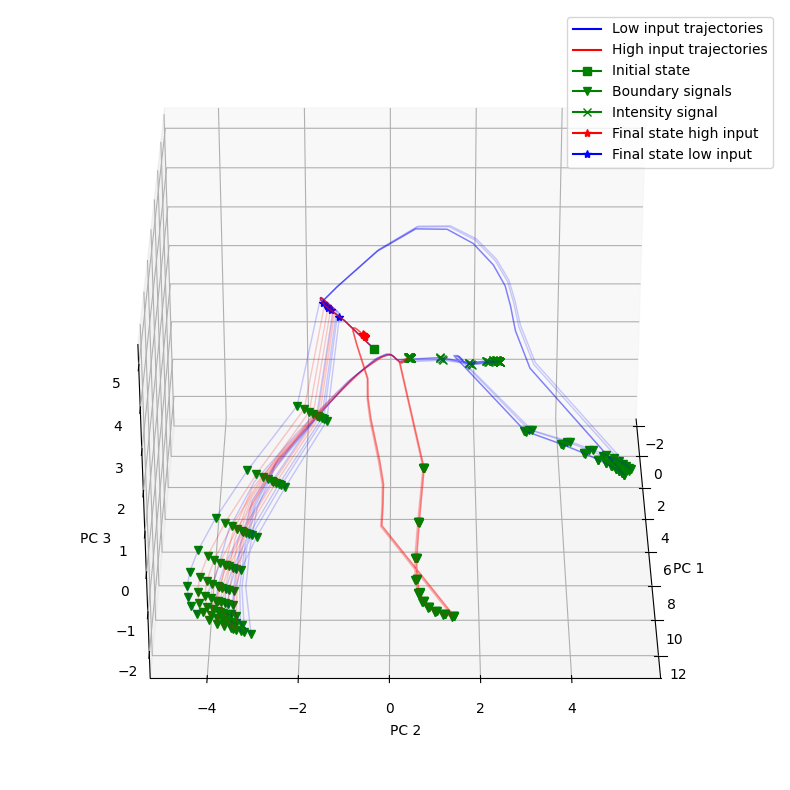

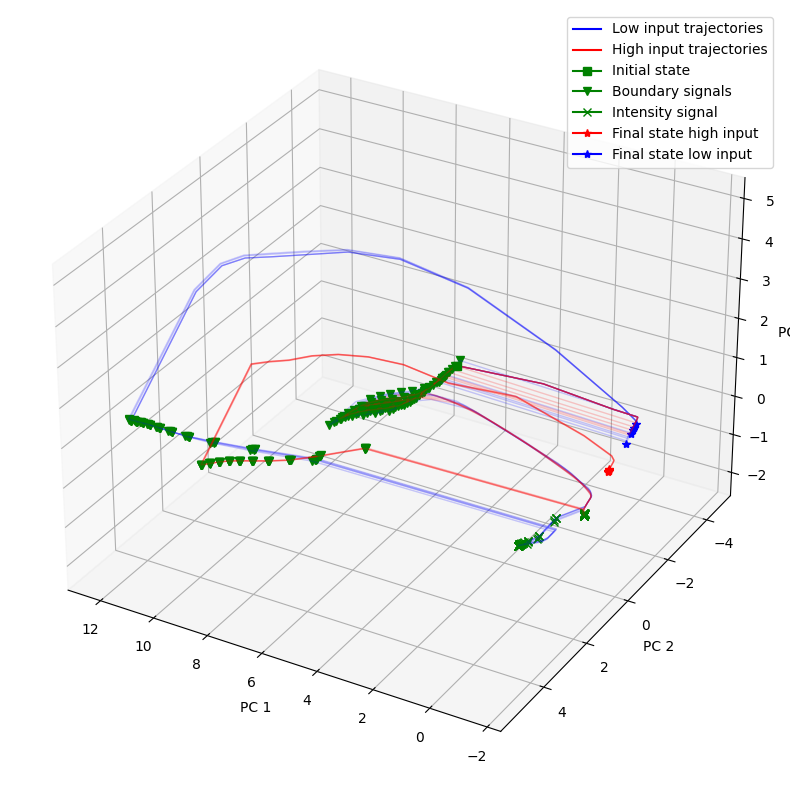

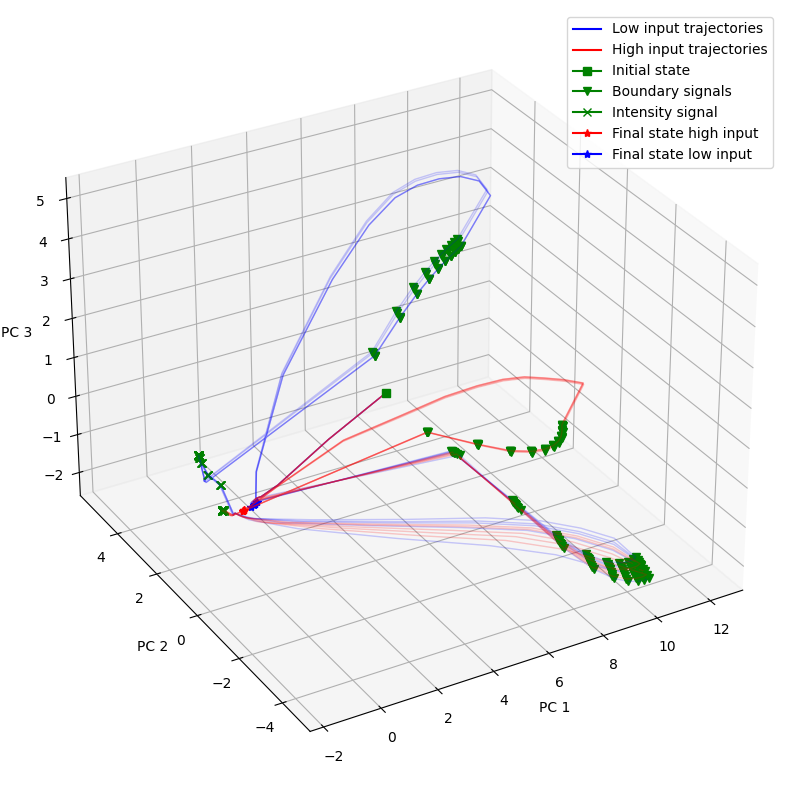

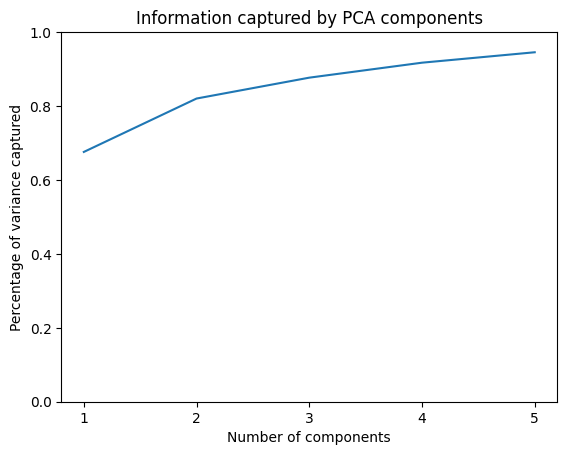

In [8]:
def perform_pca(data, n_components):
    pca = PCA(n_components=n_components, svd_solver = "full")
    pca.fit(data)
    transformed_data = pca.transform(data)
    pca_full = PCA(svd_solver = "full")
    pca_full.fit(data)
    return transformed_data, pca,pca_full.explained_variance_ratio_

def project_sample(sample, pca):
    transformed_sample = pca.transform(sample.reshape(1, -1))
    projected_sample = transformed_sample[:, :3]  # Take the first 3 principal components
    return projected_sample


def plot_N_3D_PCA_trajectories(number_of_high_trajectories, number_of_low_trajectories,cell_type): 
    input_sequences = []
    output_sequences = []
    stimG = StimGenerator(dt=.1)
    
    for i in range(number_of_high_trajectories + number_of_low_trajectories):
        ### generate the input signal
        if i < number_of_high_trajectories :
            d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=False)
        else :
            d_i, d_o = stimG.get_batch_data(1,random=False,stim_type=True)
            
        d_i, d_o = stimG.extend_sim(30, d_i, d_o)
        B, L = d_i.shape
        mod_in = torch.zeros((B,L,2))
        mod_in[...,0][d_i == 1] = 1
        mod_in[...,1][d_i != 1] = d_i[d_i!=1]
        
        ### append the input signal to later plot the different inputs input on the trajectory
        input_sequences.append((mod_in.numpy())[0,:,:].copy())
        with torch.no_grad():
            model = trained_models[cell_type]
            if cell_type == 'BEF': 
                packed = model.forward(x=mod_in, debug_mem=True)
                a,b,c,d,e,fast_var, slow_var = packed

            elif cell_type == 'BRC':
                a,c,fast_var = model.forward(x=mod_in, debug_mem=True)
            else:
                fast_var = model.forward(x=mod_in, debug_mem=True)
                
        ## append the output to the list of outputs to generate the PCA on
        output_sequences.append((fast_var[0,:,:].numpy()).copy())
        
    output_sequences = np.array(output_sequences)
    nb_principal_components = 3 ### make the PCA only on 3 components to have 3d plots
    
    ### perform the PCA decomposition
    transformed_responses, pca_fitter, info_captured = perform_pca(output_sequences.reshape(-1, output_sequences.shape[-1]),nb_principal_components)
    transformed_responses = transformed_responses.reshape(number_of_high_trajectories + number_of_low_trajectories, L, nb_principal_components)



    angles = [0, 120, 240]  # Angles for rotations
    for j,angle in enumerate(angles): 
        fig1 = plt.figure(figsize=(10, 10))
        ax1 = fig1.add_subplot(111, projection='3d')
        ax1.view_init(elev=30, azim=angle)
        for i in range(number_of_high_trajectories + number_of_low_trajectories):
            
            ### trace markers on top of trajectory
            for j in range(L):
                if input_sequences[i][j][0] > 0 : 
                    ## markers to show start/ finish pulses
                    ax1.plot(transformed_responses[i, j, 0], transformed_responses[i, j, 1],transformed_responses[i, j, 2], c = 'g',marker='v')

                elif input_sequences[i][j][1] > 0 : 
                    # market to show when signal is given to input 
                    ax1.plot(transformed_responses[i, j, 0], transformed_responses[i, j, 1],transformed_responses[i, j, 2], c = 'g',marker='x')

            ### plot trajectories
            if i < number_of_high_trajectories :
                ax1.plot(transformed_responses[i, :, 0], transformed_responses[i, :, 1], transformed_responses[i, :, 2],c = 'b', linewidth=1 ,alpha = 1/number_of_high_trajectories)
                ax1.plot(transformed_responses[i, -1, 0], transformed_responses[i, -1, 1],transformed_responses[i, -1, 2], c = 'b',marker='*')

            else: 
                ax1.plot(transformed_responses[i, :, 0], transformed_responses[i, :, 1],transformed_responses[i, :, 2],c = 'r',linewidth=1,alpha = 1/number_of_low_trajectories)
                ax1.plot(transformed_responses[i, -1, 0], transformed_responses[i, -1, 1],transformed_responses[i, -1, 2], c = 'r',marker='*')

                
        ### marker for the begining of the trajectories
        ax1.plot(transformed_responses[0, 0, 0], transformed_responses[0, 0, 1],transformed_responses[0, 0, 2], c = 'g',marker='s')
        
        ### set the labels
        ax1.plot([],[],[],c = 'b',label = 'Low input trajectories')
        ax1.plot([],[],[],c = 'r',label = 'High input trajectories')
        ax1.plot([],[],[],c = 'g',marker='s',  label='Initial state')
        ax1.plot([],[],[],c = 'g',marker='v',  label='Boundary signals')
        ax1.plot([],[],[],c = 'g',marker='x',  label='Intensity signal')
        ax1.plot([],[],[],c = 'r',marker='*',  label='Final state high input')
        ax1.plot([],[],[],c = 'b',marker='*',  label='Final state low input')
        
        ax1.legend(loc = 'best')  
        ax1.set_xlabel('PC 1')
        ax1.set_ylabel('PC 2')
        ax1.set_zlabel('PC 3')
        fig1.savefig(figures_directory_path +'/'+ cell_type +'_3d_PCA_trajectories_view_angle' + str(angle) + '.pdf')
        
    nb_components_info = 5
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(np.arange(1,nb_components_info+1),np.cumsum(info_captured)[:nb_components_info])
    ax.set_ylabel('Percentage of variance captured')
    ax.set_xlabel('Number of components')
    ax.set_xticks((np.arange(1,nb_components_info+1,1.).tolist()))
    ax.set_ylim(0, 1)
    ax.set_title('Information captured by PCA components')
    fig.savefig(figures_directory_path +'/'+ cell_type +'_PCA_variance_captured.pdf')
    
    
plot_N_3D_PCA_trajectories(5,5, 'GRU')

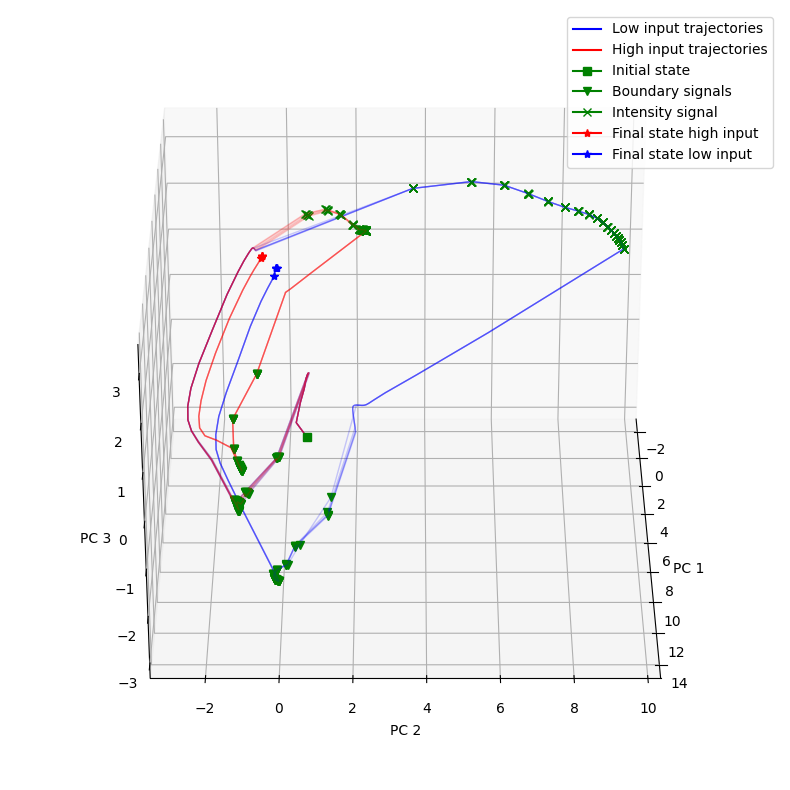

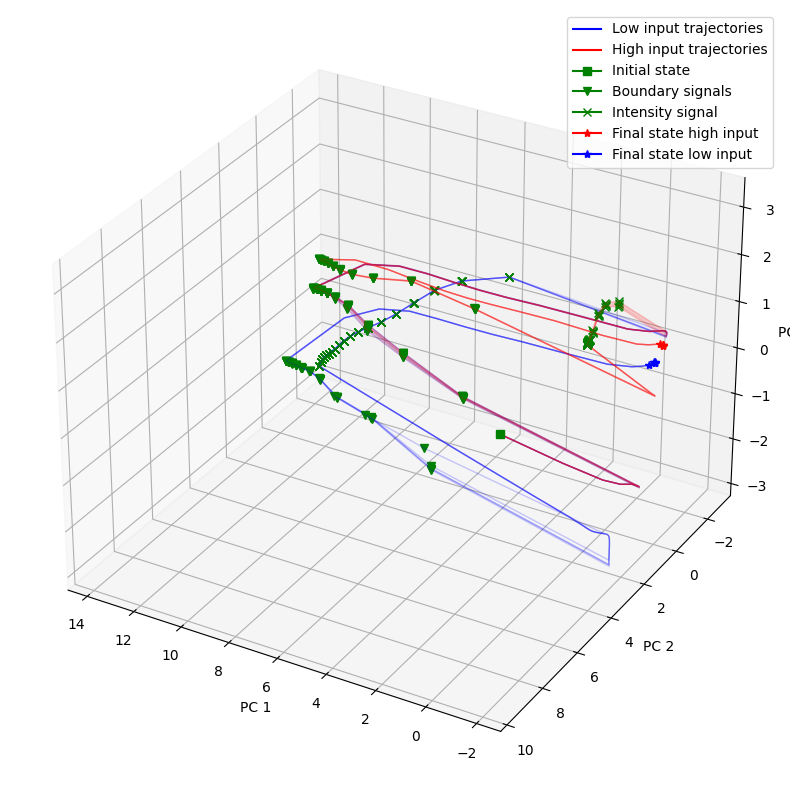

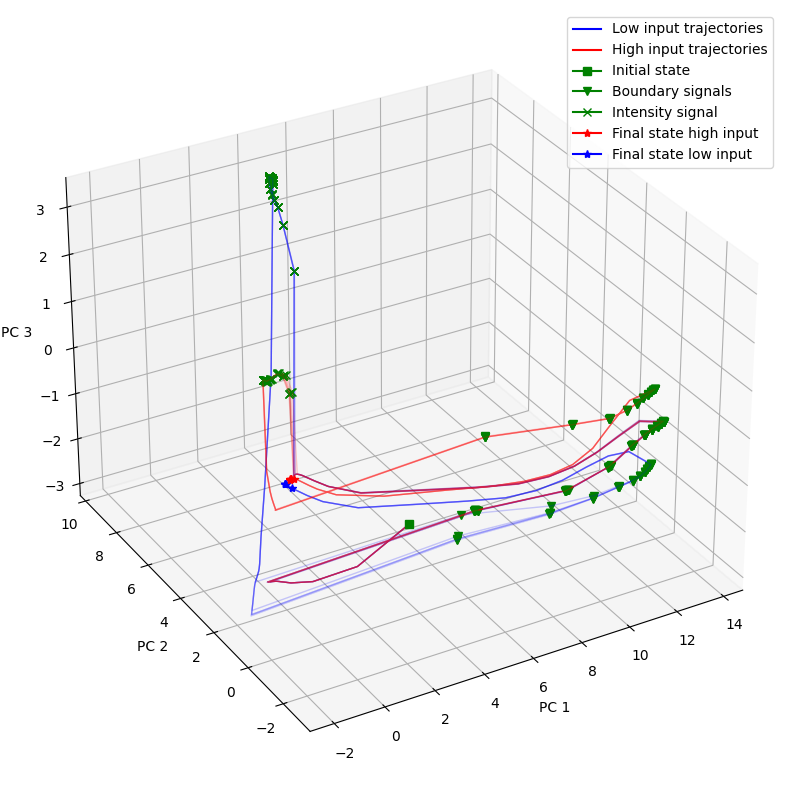

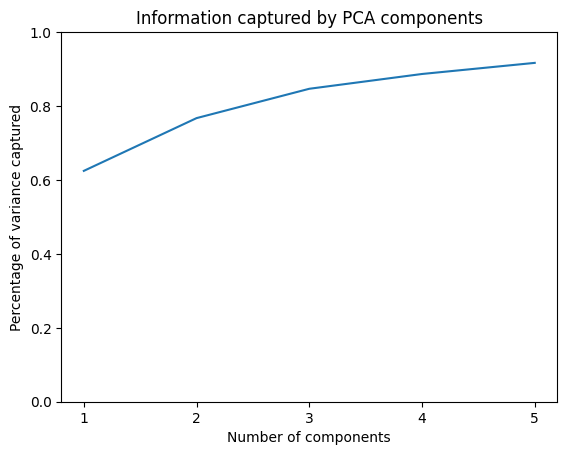

In [9]:
plot_N_3D_PCA_trajectories(5,5, 'BRC')

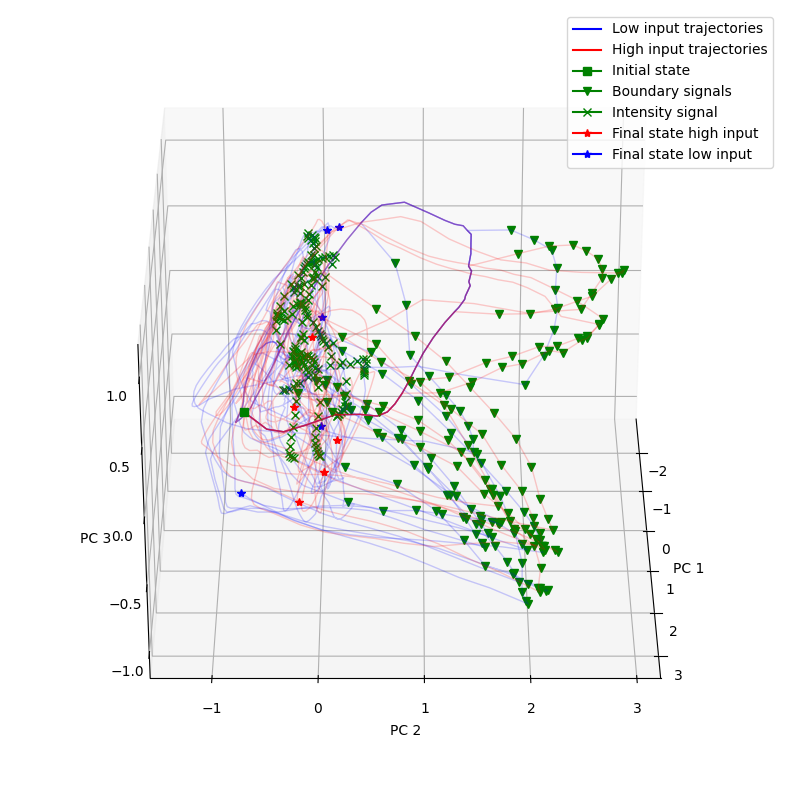

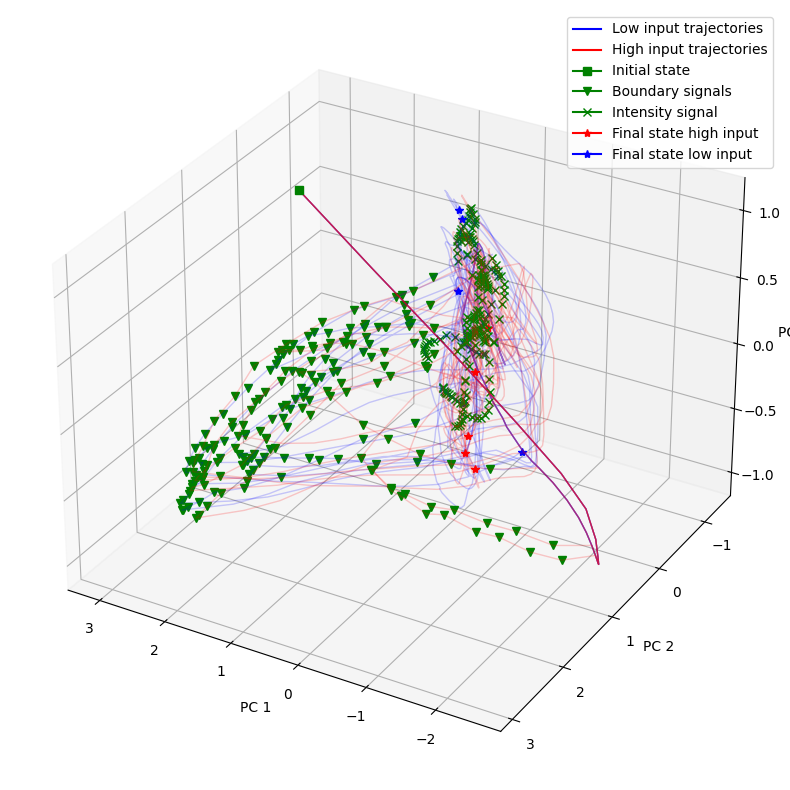

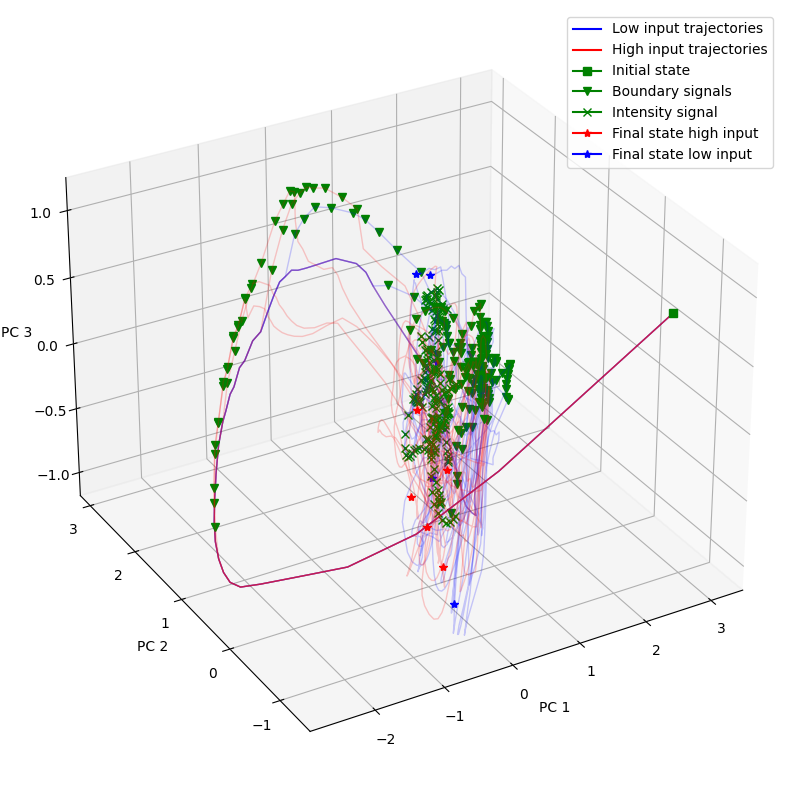

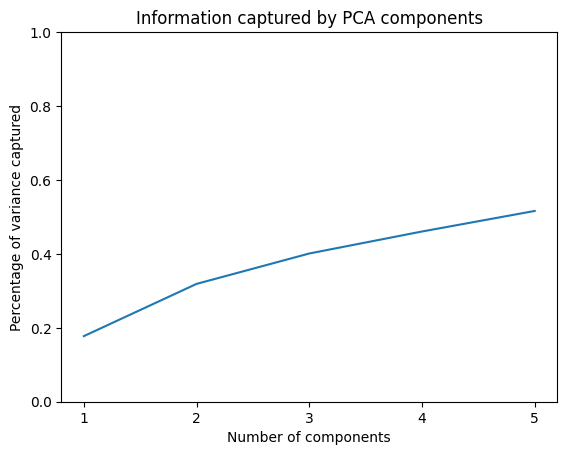

In [10]:
plot_N_3D_PCA_trajectories(5,5, 'BEF')

#### Parameter values analysis